In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns 
import folium
import warnings
warnings.filterwarnings("ignore")
import re
import matplotlib.pyplot as plt
from sklearn import preprocessing
from collections import Counter
from statsmodels.formula.api import *

/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
data_all = pd.read_csv("Iowa_Liquor_Sales.csv")
print("The entire dataset dimension: ",data_all.shape) #19666763, 24)
print("Attributes:",data_all.columns) # 19666763, 24)

The entire dataset dimension:  (19666763, 24)
Attributes: Index(['Invoice/Item Number', 'Date', 'Store Number', 'Store Name', 'Address',
       'City', 'Zip Code', 'Store Location', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Vendor Name',
       'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)',
       'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)'],
      dtype='object')


In [3]:
# check missing values 
print("Missing values:\n",data_all.isnull().sum()) 

Missing values:
 Invoice/Item Number            0
Date                           0
Store Number                   0
Store Name                     0
Address                    79927
City                       79926
Zip Code                   79971
Store Location           1886023
County Number             156731
County                    156729
Category                   16974
Category Name              25040
Vendor Number                  5
Vendor Name                    3
Item Number                    0
Item Description               0
Pack                           0
Bottle Volume (ml)             0
State Bottle Cost             10
State Bottle Retail           10
Bottles Sold                   0
Sale (Dollars)                10
Volume Sold (Liters)           0
Volume Sold (Gallons)          0
dtype: int64


In [4]:
missing_records_num = data_all[data_all.isnull().any(axis=1)].shape[0]
missing_records_num 
print(f"Missing value percentage is {100*missing_records_num / data_all.shape[0]}%.") #10.062037153750213
print(f"Total missing values is {sum(data_all.isnull().sum())}.") #2481359
print(f"Average number of null values per record" \
      f" is {sum(data_all.isnull().sum()) / missing_records_num}.") #1.253922805712533.

Missing value percentage is 10.062037153750213%.
Total missing values is 2481359.
Average number of null values per record is 1.253922805712533.


In [5]:
# drop records with missing values 
data_all = data_all.dropna()

In [6]:
data = data_all
data.Category.value_counts()
print(data.shape)#(17687886, 24)

(17687886, 24)


# Pre-processing

In [7]:
# count county names, county number, city number
county_counts = data.groupby("County").size().shape[0] #county counts 200
real_county_counts = data.groupby("County Number").size().shape[0] #99

data["County"] = data["County"].str.title() #case sensitive
exist_county_counts = data.groupby("County").size().shape #103

data["City"] = data["City"].str.title() #case sensitive

In [8]:
#pd.set_option('display.max_rows', 10)
# change county names
county_countN_df = data.loc[:,["County","County Number","Date"]].groupby(["County","County Number"]).count().reset_index()
print("Counties with the same county number but conflicting names")
county_countN_df["County Number"].value_counts()
print(county_countN_df.loc[county_countN_df["County Number"].isin([71.0, 78.0,17.0, 11.0]),:])

data.County = data.County.replace(["Buena Vist","Cerro Gord",
                                   "O'Brien","O'brien","Pottawatta"], 
                                  ["Buena Vista","Cerro Gordo",
                                    "Obrien","Obrien", "Pottawattamie"])

Counties with the same county number but conflicting names
           County  County Number    Date
10     Buena Vist           11.0   71360
11    Buena Vista           11.0   89480
17     Cerro Gord           17.0  211992
18    Cerro Gordo           17.0  228400
72        O'Brien           71.0   63180
73         Obrien           71.0   69812
80     Pottawatta           78.0  296991
81  Pottawattamie           78.0  299164


In [9]:
# convert data types 
data["Date"]  = pd.to_datetime(data['Date'],format='%m/%d/%Y')
data['year'] = pd.DatetimeIndex(data['Date']).year
data['month'] = pd.DatetimeIndex(data['Date']).month
data["month"] = data["month"].astype("category")
data['day'] = pd.DatetimeIndex(data['Date']).day
data["day"] = data["day"].astype("category")
data["week_of_day"] = data["Date"].dt.dayofweek+1
data["week_of_day"] = data["week_of_day"].astype("category")

data["Store Number"] = data["Store Number"].astype("category")
data['Item Number'] = data['Item Number'].astype('str')
data["County Number"] = data["County Number"].astype("int")
data["County Number"] = data["County Number"].astype("category")
data["Category"] = data["Category"].astype("int")
data["Category"] = data["Category"].astype("category")
data["City"] = data["City"].astype("category")
data["Sale (Dollars)"] = data["Sale (Dollars)"].astype("str")
data["State Bottle Cost"] = data["State Bottle Cost"].astype("str")
data["State Bottle Retail"] = data["State Bottle Retail"].astype("str")

data.loc[:,"Sale (Dollars)"] = data.loc[:, "Sale (Dollars)"].str[1:]
data.loc[:,"State Bottle Cost"] = data.loc[:, "State Bottle Cost"].str[1:]
data.loc[:,"State Bottle Retail"] = data.loc[:, "State Bottle Retail"].str[1:]
data["Sale (Dollars)"] = data["Sale (Dollars)"].astype("float")
data["State Bottle Cost"] = data["State Bottle Cost"].astype("float")
data["State Bottle Retail"] = data["State Bottle Retail"].astype("float")

In [10]:
# covert string representation of city to interger representation
encoder = preprocessing.LabelEncoder().fit(data.City)
data["encoded_city"] = encoder.transform(data.City)
data["encoded_city"] = data["encoded_city"].astype("category")

In [11]:
# remove potential errors 
cond1 = data["Bottle Volume (ml)"] == 0
cond2 = data["State Bottle Cost"] == 0
cond3 = data["State Bottle Retail"] == 0
cond4 = data["Sale (Dollars)"] == 0
cond5 = data["Bottles Sold"] ==0
cond6 = data["Volume Sold (Liters)"] ==0

data = data.loc[~(cond1|cond2|cond3|cond4|cond5|cond6),:] 
for i in list(data_all[~data_all['Item Number'].str.isnumeric()].index):
    data_all['Item Number'] = data_all['Item Number'][1:]
data["Item Number"] = data["Item Number"].astype("category")
data.shape
# (16113769, 29)

(16113769, 29)

In [12]:
# data from 2012-2018
cond1 = data["year"] ==2019
cond2 = data["year"] ==2020
data = data.loc[~(cond1|cond2),:] 

In [13]:
data.year.value_counts()

2018    1908163
2015    1828558
2017    1816771
2012    1788452
2016    1786149
2014    1769592
2013    1767088
Name: year, dtype: int64

In [14]:
data["Store Loc"] = data["Store Location"].map(lambda x:str(re.findall(r"\((.+?)\)",x)[0]).split(" "))
data["latitude"] = data["Store Loc"].map(lambda x:x[0])
data["longitude"] = data["Store Loc"].map(lambda x:x[1])

data["latitude"]  = data["latitude"].astype("float")
data["longitude"] = data["longitude"].astype("float")
data_filtered = data.loc[(data['longitude'] > 40.396764305572) & (data['longitude'] < 43.580390855608) & 
            (data['latitude'] < -90.087890625) & (data['latitude'] > -96.767578125)]

#-96.767578125 40.396764305572, -96.767578125 43.580390855608, -90.087890625 43.580390855608, -90.087890625 40.396764305572 
#https://geodata.iowa.gov/dataset/boundary-state-iowa
#original = (16113769, 29), after removing = (16111151, 32)
data_filtered.shape

(12662999, 32)

In [15]:
# check whether volume sold = bottlesold * bottle volume 
kk = data_filtered["Bottles Sold"]*data_filtered["Bottle Volume (ml)"]/1000 
mismatch = kk != data_filtered["Volume Sold (Liters)"] #295009
data_filtered = data_filtered.loc[~mismatch,:]

data_filtered.shape #(15745132, 32)

(12367990, 32)

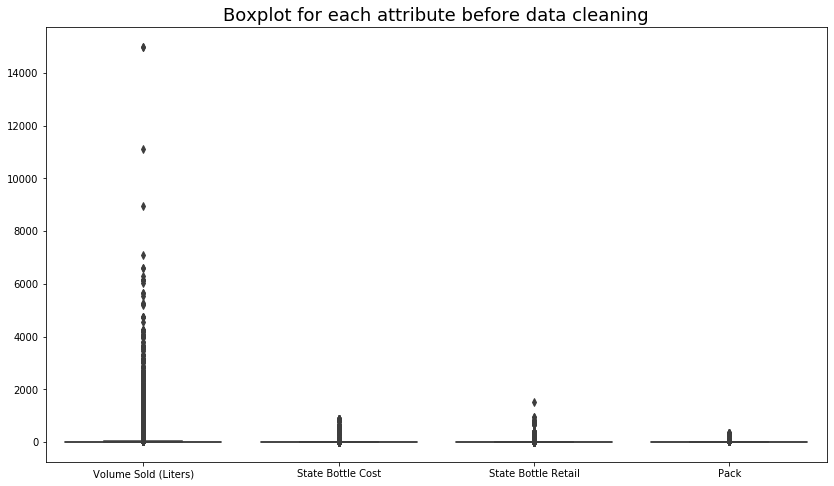

In [16]:
# boxplot for attributes before pre-processing
plt.figure(figsize=(14,8))
sns.boxplot(data = data_filtered[["Volume Sold (Liters)","State Bottle Cost",
                     "State Bottle Retail","Pack"]])
plt.title("Boxplot for each attribute before data cleaning", fontsize =18)
plt.xlabel("",fontsize =15)
plt.savefig("1.Boxplot for each attribute before data cleaning.jpg")

In [17]:
def drop_3IQR_val(df, col_name):
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    IQR = q3 - q1
    df_new = df.drop(df[(df[col_name] > q3 + 3*IQR) | (df[col_name] < q1 - 3*IQR)].index)
    print("feature = ",col_name, ":",df.shape[0]- df_new.shape[0],"records removed",df_new.shape[0],"records remaning" )
    return (df_new)

targeted_features = ["Volume Sold (Liters)","State Bottle Cost",
                     "State Bottle Retail","Pack"]
for i in targeted_features:
    data_filtered = drop_3IQR_val(data_filtered, i)
#13795216

feature =  Volume Sold (Liters) : 285167 records removed 12082823 records remaning
feature =  State Bottle Cost : 933404 records removed 11149419 records remaning
feature =  State Bottle Retail : 943 records removed 11148476 records remaning
feature =  Pack : 294661 records removed 10853815 records remaning


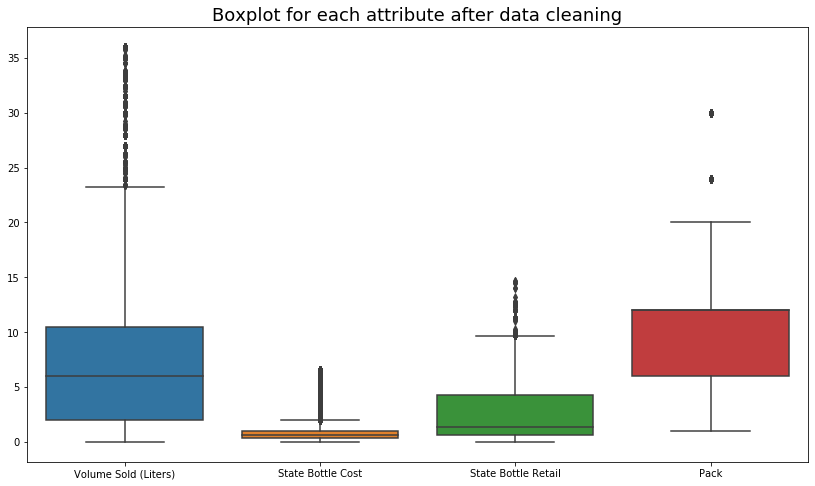

In [18]:
# boxplot for attributes after pre-processing
plt.figure(figsize=(14,8))
sns.boxplot(data = data_filtered[["Volume Sold (Liters)","State Bottle Cost",
                     "State Bottle Retail","Pack"]])
plt.title("Boxplot for each attribute after data cleaning", fontsize =18)
plt.xlabel("",fontsize =15)
plt.savefig("2.Boxplot for each attribute after data cleaning.jpg")

In [19]:
# number of stores in the county
num_store_per_county = data_filtered[['Store Number','County Number',"Invoice/Item Number"]].groupby(["County Number","Store Number"])
z = list(num_store_per_county.groups.keys())
store_num_counter = Counter(elem[0] for elem in z)
df_store = pd.DataFrame.from_dict(store_num_counter, orient = "index").reset_index()
df_store.columns = ["County Number","store_num"]

data_filtered = pd.merge(data_filtered, df_store, how = "left", on = ['County Number'])
data_filtered.shape #(13795216, 33)

(10853815, 33)

In [20]:
# feature selection by human interpretation
data_filtered = data_filtered[['year', 'month', 'day', 'latitude','longitude',
                            'week_of_day','Pack','City', 'Category','County Number',
                            'County', 'store_num', 'Item Number','Bottle Volume (ml)',
                            'State Bottle Cost', 'State Bottle Retail',
                            'Volume Sold (Liters)','Store Number', 'encoded_city']]
data_filtered.rename(columns = {"County Number":"county_number", 
                             "Volume Sold (Liters)":"volume_sold",
                             "Pack":"pack",
                             "City":"city","Category":"category",
                             "Store Number":"store_number",
                             "State Bottle Retail":"retail_price",
                             "State Bottle Cost":"cost_price",
                             "County Number":"county_number",
                             "County": "county",
                             "Item Number":"item_number",
                             "Bottle Volume (ml)":"bottle_volume"}, inplace = True)

In [21]:
data_filtered["county_number"] = data_filtered["county_number"].astype("category")
data_filtered.dtypes

year                int64
month            category
day              category
latitude          float64
longitude         float64
week_of_day      category
pack                int64
city             category
category         category
county_number    category
county             object
store_num           int64
item_number      category
bottle_volume       int64
cost_price        float64
retail_price      float64
volume_sold       float64
store_number     category
encoded_city     category
dtype: object

In [22]:
# sample 200k records
data_final = data_filtered.sample(n = 200000, replace = False, random_state = 100)

# merge population dataset
population = pd.read_csv("County_Population_in_Iowa_by_Year.csv")
population = population[["year","population",'county']]
print("Missing values:\n",population.isnull().sum()) 

Missing values:
 year          0
population    0
county        0
dtype: int64


In [23]:
#population
population.population = population.population.astype("int")
data_final = pd.merge(data_final,population,how = "left")

In [24]:
data_final.dtypes

year                int64
month            category
day              category
latitude          float64
longitude         float64
week_of_day      category
pack                int64
city             category
category         category
county_number    category
county             object
store_num           int64
item_number      category
bottle_volume       int64
cost_price        float64
retail_price      float64
volume_sold       float64
store_number     category
encoded_city     category
population          int64
dtype: object

# Feature Selection

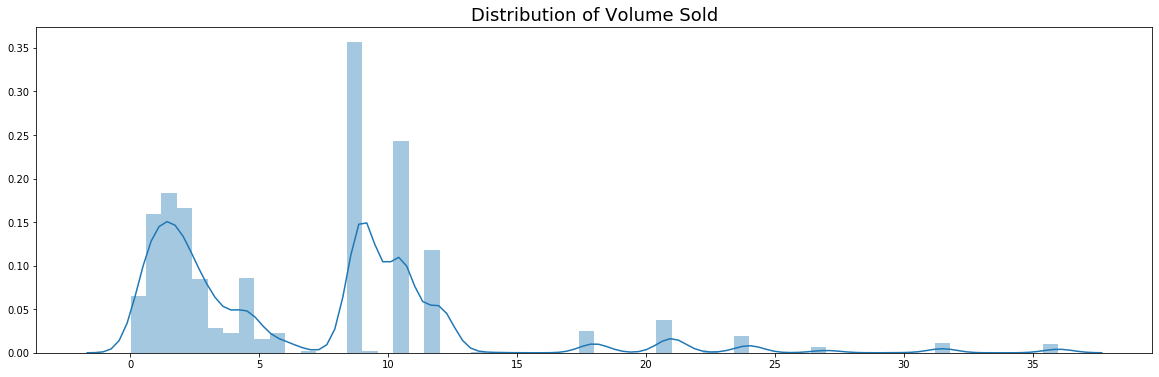

In [25]:
# Distribution of Volume Sold
plt.figure(figsize=(20,6))
sns.distplot(data_final['volume_sold'], bins=60)
plt.title("Distribution of Volume Sold", fontsize =18)
plt.xlabel("",fontsize =15)
plt.savefig("3.Distribution of Volume Sold.pdf")

In [26]:
data_final[['pack', 'store_num', 'bottle_volume','retail_price', 'cost_price', 'population', 'volume_sold']].describe()

,pack,store_num,bottle_volume,retail_price,cost_price,population,volume_sold
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,11.277915,84.036530,944.058925,2.697524,1.252586,146392.600520,7.007196
std,4.517000,84.714822,456.251818,2.726469,1.511722,159025.023885,6.080006
min,1.000000,1.000000,20.000000,0.010000,0.010000,3645.000000,0.020000
25%,6.000000,16.000000,750.000000,0.610000,0.370000,21018.000000,2.000000
50%,12.000000,52.000000,750.000000,1.400000,0.660000,93871.000000,6.000000
75%,12.000000,145.000000,1000.000000,4.250000,1.030000,215462.000000,10.500000
max,30.000000,248.000000,6000.000000,12.500000,6.610000,487204.000000,36.000000


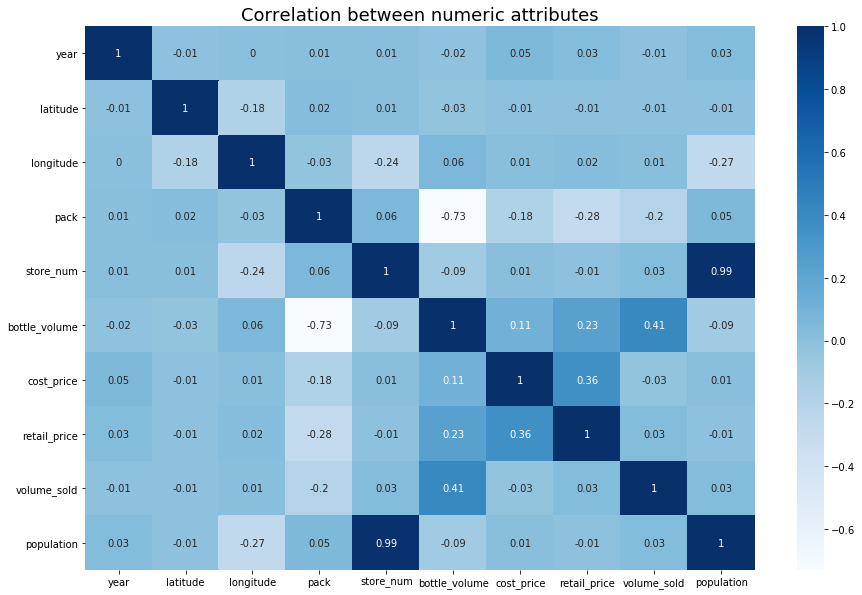

In [27]:
# Correction between selected attributes
fig, ax = plt.subplots(figsize = (15, 10))
corr = data_final.corr(method='pearson').round(2)
sns.heatmap(corr, annot = True, cmap = 'Blues')
plt.title(f'Correlation between numeric attributes', fontsize = 18)
plt.rc('xtick',labelsize = 10)
plt.rc('ytick',labelsize = 10)
fig.savefig('4.Correlation between numeric attributes.pdf')

In [28]:
# high correlation between attributes
data_final = data_final.drop(['pack', 'store_num'], axis = 1)

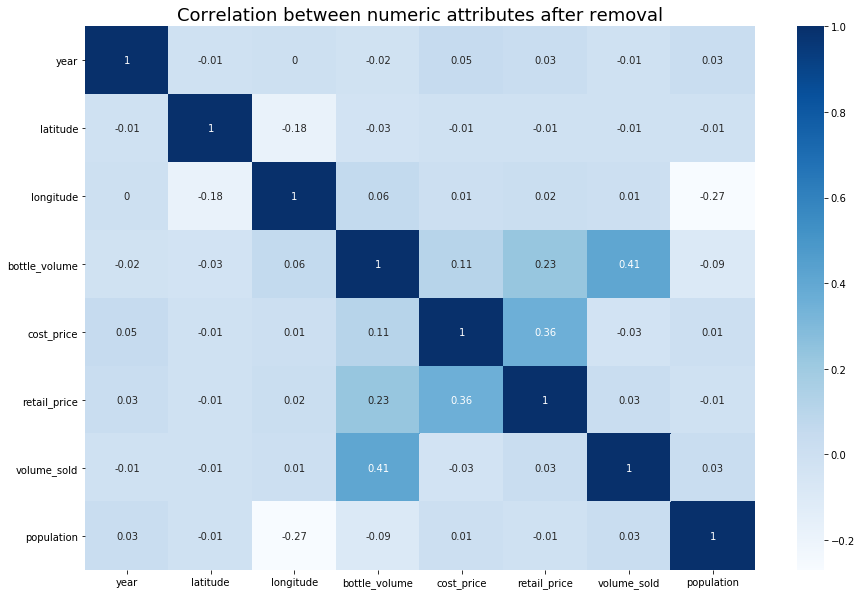

In [29]:
# Correction between selected attributes after removal
fig, ax = plt.subplots(figsize = (15, 10))
cor = data_final.corr(method='pearson').round(2)
sns.heatmap(cor, annot = True, cmap = 'Blues')
plt.title(f'Correlation between numeric attributes after removal', fontsize = 18)
plt.rc('xtick',labelsize = 10)
plt.rc('ytick',labelsize = 10)
fig.savefig('5.Correlation between numeric attributes after removal.pdf')

corr_df = pd.DataFrame(cor['volume_sold']).iloc[:6,:]
corr_df_x = corr_df.index.values.tolist()
corr_df_x.append('population')
corr_df_y = list(cor['volume_sold'])[0:-2]
corr_df_y.append(cor['volume_sold'][-1])

In [30]:
def compute_corr_categorical(formula, feature_name):
    fit = ols(formula, data = data_final).fit()
    fitted_val = pd.Series(fit.fittedvalues)
    cor = round(fitted_val.corr(data_final.volume_sold, method='pearson'), 6)
    print("Pearson correlation between volume sold and ", feature_name, " is: ", cor)
    return (cor)

# correlation with categorical attributes
month_corr = compute_corr_categorical("volume_sold ~ month", "month")
day_corr = compute_corr_categorical("volume_sold ~ day", "day")
week_day_corr = compute_corr_categorical("volume_sold ~ week_of_day", "week_of_day")
encoded_city_corr = compute_corr_categorical("volume_sold ~ encoded_city", "encoded_city")
category_corr = compute_corr_categorical("volume_sold ~ category", "category")
county_corr = compute_corr_categorical("volume_sold ~ county_number", "county_number")
store_number_corr = compute_corr_categorical("volume_sold ~ store_number", "store_number")
item_corr = compute_corr_categorical("volume_sold ~ item_number", "item_number")

Pearson correlation between volume sold and  month  is:  0.015144
Pearson correlation between volume sold and  day  is:  0.015598
Pearson correlation between volume sold and  week_of_day  is:  0.033548
Pearson correlation between volume sold and  encoded_city  is:  0.217012
Pearson correlation between volume sold and  category  is:  0.304143
Pearson correlation between volume sold and  county_number  is:  0.129725
Pearson correlation between volume sold and  store_number  is:  0.442656
Pearson correlation between volume sold and  item_number  is:  0.593937


In [31]:
corr_df_x.extend(['month', 'day', 'week_of_day', 'encoded_city', 'category', 'county_number',
                  'store_number', 'item_number'])
corr_df_y.extend([month_corr, day_corr, week_day_corr, encoded_city_corr,
                 category_corr, county_corr, store_number_corr, item_corr])

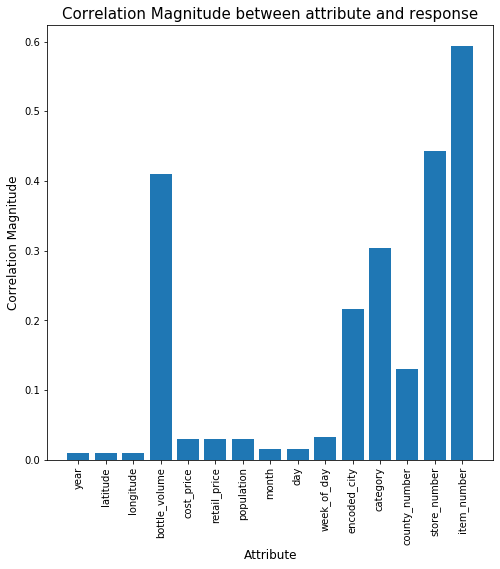

In [32]:
# correlation with attributes
corr_df_y = [abs(x) for x in corr_df_y] #absolute value
fig, ax = plt.subplots(figsize = (8,8)) 
plt.bar(x = corr_df_x, height = corr_df_y)

ax.set_title(f'Correlation Magnitude between attribute and response', fontsize = 15)
ax.set_xlabel('Attribute', fontsize = 12) 
plt.xticks(rotation=90)
ax.set_ylabel('Correlation Magnitude', fontsize = 12) 
plt.rc('xtick', labelsize = 15) 
plt.rc('ytick',labelsize = 8) 
fig.savefig('6.Correlation Magnitude between attribute and response.pdf') 
plt.show()

In [33]:
# drop low correlation
drop_column = []
for i in range (len(corr_df_y)):
    if corr_df_y[i] < 0.02:
        drop_column.append(corr_df_x[i])
data_final = data_final.drop(columns = drop_column)
# save files
data_final.to_csv("data_200k_latest.csv")

In [34]:
data_final.dtypes

week_of_day      category
city             category
category         category
county_number    category
county             object
item_number      category
bottle_volume       int64
cost_price        float64
retail_price      float64
volume_sold       float64
store_number     category
encoded_city     category
population          int64
dtype: object

# Visualization

### Boxplot of volume vs week of day

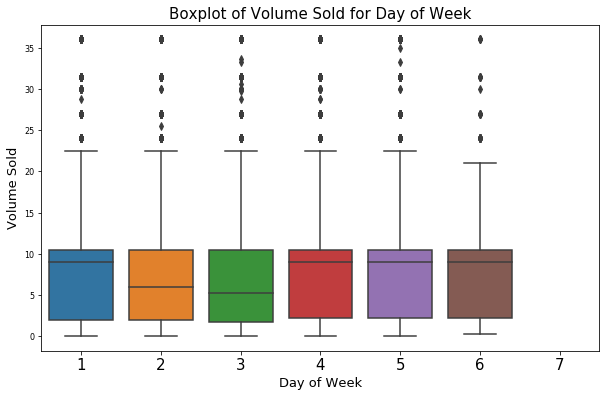

In [35]:
# Boxplot of Volume Sold for Day of Week
plt.figure(figsize=(10,6))
sns.boxplot(x = 'week_of_day', y = 'volume_sold', data = data_final[["week_of_day","volume_sold"]])
plt.ylabel('Volume Sold', fontsize = 13)
plt.xlabel('Day of Week', fontsize = 13)
plt.title("Boxplot of Volume Sold for Day of Week", fontsize =15)
plt.rc('xtick', labelsize = 15) 
plt.rc('ytick',labelsize = 15) 
plt.savefig("7.Boxplot of Volume Sold for Day of Week.pdf")
plt.show()

### Choropleth Plot for volume sold

In [36]:
# Choropleth Plot for volume sold
sf = gpd.read_file("county.shp")
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
gdf_PUL = gpd.GeoDataFrame(pd.merge(data_final, sf, left_on = 'county', 
                                right_on = 'COUNTY')).drop('county', axis = 1)

geoJSON = gdf_PUL[['geometry','COUNTY']].drop_duplicates('COUNTY').to_json()
pd.set_option('display.max_rows', 103)
data_final.county.value_counts()

# Analyze total alcohol sales in different counties (chorolength)
volume_sold_df = data_final.loc[:, ["county", "volume_sold"]].groupby("county").sum().reset_index() # 99 counties


td_map = folium.Map(location = [41.8780, -93.0977], 
                    zoom_start= 7,tiles = "cartodbpositron")

cho_map = folium.Choropleth(
    geo_data=geoJSON,
    data=volume_sold_df[['county','volume_sold']],
    name='choropleth',
    fill_color='YlGn',
    fill_opacity=0.7,
    key_on = 'feature.properties.COUNTY',
    line_opacity=0.2,
    legend_name='volume_sold',
    highlight=True,
    line_color='green',
    columns = ['county','volume_sold'], reset = True,
).add_to(td_map)

cho_map.geojson.add_child(folium.features.GeoJsonTooltip(['COUNTY'], labels = False))
folium.LayerControl().add_to(td_map)
td_map.save('8.foliumChoropleth_map_volume_sold.html')
#td_map